## **Effect of Inhibition Factor (C / α)**   
KCin = (KCin - C*Uin)/Sigma to pass through.


Testing with alpha = 0.01
Test Accuracy with alpha = 0.01: 82.14%
Testing with alpha = 0.06
Test Accuracy with alpha = 0.06: 83.56%
Testing with alpha = 0.11
Test Accuracy with alpha = 0.11: 83.70%
Testing with alpha = 0.16
Test Accuracy with alpha = 0.16: 85.32%
Testing with alpha = 0.21
Test Accuracy with alpha = 0.21: 85.68%
Testing with alpha = 0.26
Test Accuracy with alpha = 0.26: 82.59%
Testing with alpha = 0.31
Test Accuracy with alpha = 0.31: 76.45%
Testing with alpha = 0.36
Test Accuracy with alpha = 0.36: 58.51%
Testing with alpha = 0.41
Test Accuracy with alpha = 0.41: 50.31%
Testing with alpha = 0.46
Test Accuracy with alpha = 0.46: 47.05%


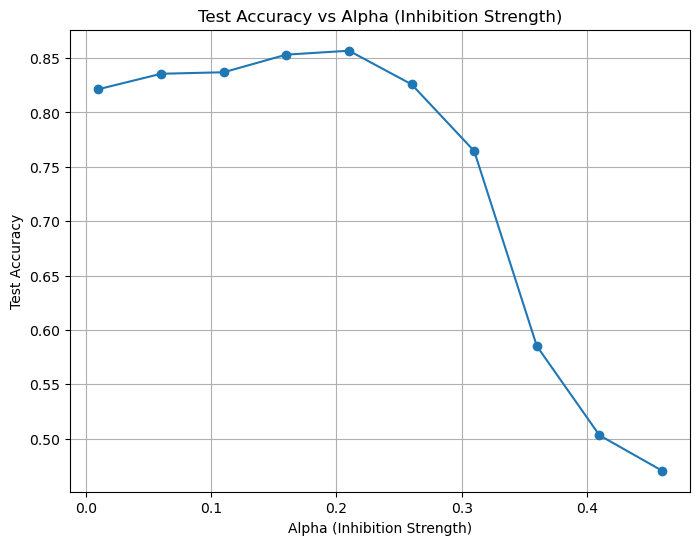

In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 2. Sparse Projection Matrix Generator
def generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden):
    """
    Generates a sparse binary projection matrix.
    """
    projection = torch.zeros(hidden_dim, input_dim)
    for i in range(hidden_dim):
        selected_indices = torch.randperm(input_dim)[:connections_per_hidden]
        projection[i, selected_indices] = 1
    return projection

# 3. KCNet Model with Input Gain Control Inhibition and Dynamic Alpha
class KCNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, connections_per_hidden, alpha=0.1):
        """
        Initializes the KCNet model with adjustable inhibition strength (alpha).
        """
        super(KCNet, self).__init__()
        self.projection_matrix = generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden)
        self.output_weights = None  # To be trained using ridge regression
        self.hidden_dim = hidden_dim
        self.alpha = alpha  # Default inhibition strength

    def forward(self, x):
        """
        Forward pass for KCNet with input gain control inhibition.
        """
        # Step 1: Random projection
        hidden_activations = torch.matmul(x, self.projection_matrix.T)
        
        # Step 2: Input Gain Control Inhibition with dynamic alpha
        mean_activation = hidden_activations.mean(dim=1, keepdim=True)
        std_activation = hidden_activations.std(dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        inhibited_activations = (hidden_activations - self.alpha * mean_activation) / std_activation
        
        # Step 3: ReLU activation to enforce sparsity
        sparse_output = torch.relu(inhibited_activations)
        
        # Step 4: Linear output layer
        output = sparse_output @ self.output_weights
        return output

    def train_output_layer(self, hidden_layer_outputs, targets, lambda_reg=0.01):
        """
        Trains the output layer weights using ridge regression.
        """
        H_T = hidden_layer_outputs.T
        regularization = lambda_reg * torch.eye(H_T.shape[0])

        try:
            ridge_matrix = torch.inverse(H_T @ hidden_layer_outputs + regularization)
            self.output_weights = ridge_matrix @ H_T @ targets
        except Exception as e:
            print(f"Error during matrix inversion: {e}")

# 4. Training Function
def train_kcnet(model, train_loader, lambda_reg=0.1):
    """
    Trains the KCNet's output weights using ridge regression.
    """
    all_hidden_outputs = []
    all_targets = []

    # Collect hidden layer outputs and targets
    for data, target in train_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        hidden_activations = torch.relu(data @ model.projection_matrix.T)
        all_hidden_outputs.append(hidden_activations)
        all_targets.append(torch.nn.functional.one_hot(target, num_classes=output_dim).float())

    # Combine all batches
    hidden_outputs = torch.cat(all_hidden_outputs, dim=0)
    targets = torch.cat(all_targets, dim=0)

    # Train output weights
    model.train_output_layer(hidden_outputs, targets, lambda_reg)

# 5. Evaluation Function
def evaluate_kcnet(model, data_loader):
    """
    Evaluates the KCNet model on a dataset.
    """
    all_predictions = []
    all_labels = []

    for data, target in data_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        output = model(data)
        predictions = output.argmax(dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# 6. Training and Evaluation Pipeline
input_dim = 28 * 28  # Flattened MNIST images
hidden_dim = 6500    # Hidden neurons (Kenyon cells)
output_dim = 10      # Number of classes (digits 0-9)
connections_per_hidden = 7  # Sparse connections

# Evaluate KCNet for different alpha values
alpha_values = np.arange(0.01, 0.5, 0.05)  # Range of alpha values to test
accuracies = []

# Train and evaluate for each alpha value
for alpha in alpha_values:
    print(f"Testing with alpha = {alpha:.2f}")
    
    # Initialize KCNet with current alpha
    kcnet = KCNet(input_dim, hidden_dim, output_dim, connections_per_hidden, alpha=alpha)
    
    # Train the output layer
    train_kcnet(kcnet, train_loader, lambda_reg=0.1)
    
    # Evaluate the model
    test_accuracy = evaluate_kcnet(kcnet, test_loader)
    accuracies.append(test_accuracy)
    print(f"Test Accuracy with alpha = {alpha:.2f}: {test_accuracy * 100:.2f}%")

# 7. Plot Accuracy vs Alpha
plt.figure(figsize=(8, 6))
plt.plot(alpha_values, accuracies, marker='o')
plt.xlabel('Alpha (Inhibition Strength)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Alpha (Inhibition Strength)')
plt.grid(True)
plt.savefig('accuracy_vs_alpha.png', dpi=300, bbox_inches='tight')  # Save high-quality plot
plt.show()


## **Effect of lambda in Moore-Penrose Inverse on Input Gain Control Inhibtion**  

Test Accuracy with lambda=0.01: 83.51%
Test Accuracy with lambda=0.02: 83.80%
Test Accuracy with lambda=0.03: 83.94%
Test Accuracy with lambda=0.04: 84.03%
Test Accuracy with lambda=0.05: 84.07%
Test Accuracy with lambda=0.06: 84.16%
Test Accuracy with lambda=0.07: 84.21%
Test Accuracy with lambda=0.08: 84.27%
Test Accuracy with lambda=0.09: 84.30%
Test Accuracy with lambda=0.10: 84.40%
Test Accuracy with lambda=0.11: 84.44%
Test Accuracy with lambda=0.12: 84.49%
Test Accuracy with lambda=0.13: 84.53%
Test Accuracy with lambda=0.14: 84.53%
Test Accuracy with lambda=0.15: 84.55%
Test Accuracy with lambda=0.16: 84.55%
Test Accuracy with lambda=0.17: 84.58%
Test Accuracy with lambda=0.18: 84.64%
Test Accuracy with lambda=0.19: 84.69%
Test Accuracy with lambda=0.20: 84.71%
Test Accuracy with lambda=0.21: 84.70%
Test Accuracy with lambda=0.22: 84.71%
Test Accuracy with lambda=0.23: 84.72%
Test Accuracy with lambda=0.24: 84.73%
Test Accuracy with lambda=0.25: 84.76%
Test Accuracy with lambda

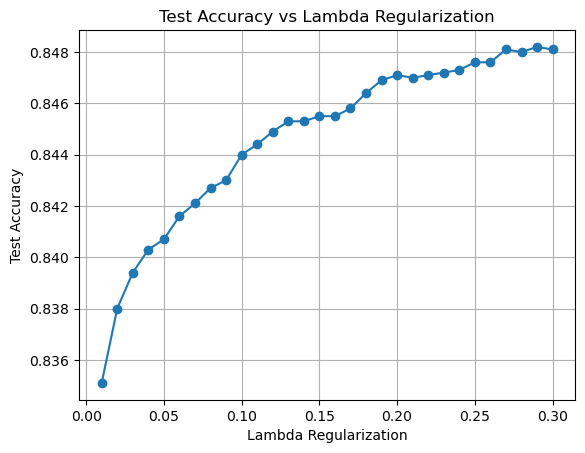

In [13]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


# 2. Sparse Projection Matrix Generator
def generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden):
    """
    Generates a sparse binary projection matrix.
    """
    projection = torch.zeros(hidden_dim, input_dim)
    for i in range(hidden_dim):
        selected_indices = torch.randperm(input_dim)[:connections_per_hidden]
        projection[i, selected_indices] = 1
    return projection


# 3. KCNet Model with Input Gain Control Inhibition
class KCNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, connections_per_hidden):
        """
        Initializes the KCNet model.
        """
        super(KCNet, self).__init__()
        self.projection_matrix = generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden)
        self.output_weights = None  # To be trained using ridge regression
        self.hidden_dim = hidden_dim

    def forward(self, x):
        """
        Forward pass for KCNet with input gain control inhibition.
        """
        # Step 1: Random projection
        hidden_activations = torch.matmul(x, self.projection_matrix.T)
        
        # Step 2: Input Gain Control Inhibition
        mean_activation = hidden_activations.mean(dim=1, keepdim=True)
        std_activation = hidden_activations.std(dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        alpha = 0.1  # Inhibition strength factor
        inhibited_activations = (hidden_activations - 0.21 * (mean_activation)) / std_activation
        
        # Step 3: ReLU activation to enforce sparsity
        sparse_output = torch.relu(inhibited_activations)
        
        # Step 4: Linear output layer
        output = sparse_output @ self.output_weights
        return output

    def train_output_layer(self, hidden_layer_outputs, targets, lambda_reg=0.01):
        """
        Trains the output layer weights using ridge regression.
        """
        H_T = hidden_layer_outputs.T
        regularization = lambda_reg * torch.eye(H_T.shape[0])

        try:
            ridge_matrix = torch.inverse(H_T @ hidden_layer_outputs + regularization)
            self.output_weights = ridge_matrix @ H_T @ targets
        except Exception as e:
            print(f"Error during matrix inversion: {e}")


# 4. Training Function
def train_kcnet(model, train_loader, lambda_reg=0.1):
    """
    Trains the KCNet's output weights using ridge regression.
    """
    all_hidden_outputs = []
    all_targets = []

    # Collect hidden layer outputs and targets
    for data, target in train_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        hidden_activations = torch.relu(data @ model.projection_matrix.T)
        all_hidden_outputs.append(hidden_activations)
        all_targets.append(torch.nn.functional.one_hot(target, num_classes=output_dim).float())

    # Combine all batches
    hidden_outputs = torch.cat(all_hidden_outputs, dim=0)
    targets = torch.cat(all_targets, dim=0)

    # Train output weights
    model.train_output_layer(hidden_outputs, targets, lambda_reg)


# 5. Evaluation Function
def evaluate_kcnet(model, data_loader):
    """
    Evaluates the KCNet model on a dataset.
    """
    all_predictions = []
    all_labels = []

    for data, target in data_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        output = model(data)
        predictions = output.argmax(dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy


# 6. Training and Evaluation Pipeline
input_dim = 28 * 28  # Flattened MNIST images
hidden_dim = 6500    # Hidden neurons (Kenyon cells)
output_dim = 10      # Number of classes (digits 0-9)
connections_per_hidden = 7  # Sparse connections

# Initialize KCNet
kcnet = KCNet(input_dim, hidden_dim, output_dim, connections_per_hidden)
# 7. Plot Accuracy vs Lambda Regularization
lambda_values = np.arange(0.01, 0.31, 0.01)
accuracies = []

for lambda_reg in lambda_values:
    train_kcnet(kcnet, train_loader, lambda_reg=lambda_reg)
    test_accuracy = evaluate_kcnet(kcnet, test_loader)
    accuracies.append(test_accuracy)
    print(f"Test Accuracy with lambda={lambda_reg:.2f}: {test_accuracy * 100:.2f}%")

# Plot Accuracy vs Lambda Regularization
plt.plot(lambda_values, accuracies, marker='o')
plt.xlabel('Lambda Regularization')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Lambda Regularization')
plt.grid(True)
plt.savefig('accuracy_vs_lambda_inhibition_Input_Gain_control.png', dpi=300, bbox_inches='tight')  # Save high-quality plot



**Over All C=0.21 and lambda=0.3**

In [19]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


# 2. Sparse Projection Matrix Generator
def generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden):
    """
    Generates a sparse binary projection matrix.
    """
    projection = torch.zeros(hidden_dim, input_dim)
    for i in range(hidden_dim):
        selected_indices = torch.randperm(input_dim)[:connections_per_hidden]
        projection[i, selected_indices] = 1
    return projection


# 3. KCNet Model with Input Gain Control Inhibition
class KCNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, connections_per_hidden):
        """
        Initializes the KCNet model.
        """
        super(KCNet, self).__init__()
        self.projection_matrix = generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden)
        self.output_weights = None  # To be trained using ridge regression
        self.hidden_dim = hidden_dim

    def forward(self, x):
        """
        Forward pass for KCNet with input gain control inhibition.
        """
        # Step 1: Random projection
        hidden_activations = torch.matmul(x, self.projection_matrix.T)
        
        # Step 2: Input Gain Control Inhibition
        mean_activation = hidden_activations.mean(dim=1, keepdim=True)
        std_activation = hidden_activations.std(dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        alpha = 0.1  # Inhibition strength factor
        inhibited_activations = (hidden_activations - 0.21 * (mean_activation)) / std_activation
        
        # Step 3: ReLU activation to enforce sparsity
        sparse_output = torch.relu(inhibited_activations)
        
        # Step 4: Linear output layer
        output = sparse_output @ self.output_weights
        return output

    def train_output_layer(self, hidden_layer_outputs, targets, lambda_reg=0.01):
        """
        Trains the output layer weights using ridge regression.
        """
        H_T = hidden_layer_outputs.T
        regularization = lambda_reg * torch.eye(H_T.shape[0])

        try:
            ridge_matrix = torch.inverse(H_T @ hidden_layer_outputs + regularization)
            self.output_weights = ridge_matrix @ H_T @ targets
        except Exception as e:
            print(f"Error during matrix inversion: {e}")


# 4. Training Function
def train_kcnet(model, train_loader, lambda_reg=0.1):
    """
    Trains the KCNet's output weights using ridge regression.
    """
    all_hidden_outputs = []
    all_targets = []

    # Collect hidden layer outputs and targets
    for data, target in train_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        hidden_activations = torch.relu(data @ model.projection_matrix.T)
        all_hidden_outputs.append(hidden_activations)
        all_targets.append(torch.nn.functional.one_hot(target, num_classes=output_dim).float())

    # Combine all batches
    hidden_outputs = torch.cat(all_hidden_outputs, dim=0)
    targets = torch.cat(all_targets, dim=0)

    # Train output weights
    model.train_output_layer(hidden_outputs, targets, lambda_reg)


# 5. Evaluation Function
def evaluate_kcnet(model, data_loader):
    """
    Evaluates the KCNet model on a dataset.
    """
    all_predictions = []
    all_labels = []

    for data, target in data_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        output = model(data)
        predictions = output.argmax(dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy


# 6. Training and Evaluation Pipeline
input_dim = 28 * 28  # Flattened MNIST images
hidden_dim = 6500    # Hidden neurons (Kenyon cells)
output_dim = 10      # Number of classes (digits 0-9)
connections_per_hidden = 7  # Sparse connections

# Initialize KCNet
kcnet = KCNet(input_dim, hidden_dim, output_dim, connections_per_hidden)

# Train and evaluate the model for multiple runs
n_runs = 5
results = []

for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}")
    train_kcnet(kcnet, train_loader, lambda_reg=0.3)
    test_accuracy = evaluate_kcnet(kcnet, test_loader)
    print(f"Test Accuracy for run {run + 1}: {test_accuracy * 100:.2f}%")
    results.append(test_accuracy)

# Calculate and display average accuracy and standard deviation
average_result = np.mean(results)
std_deviation = np.std(results)

print(f"Average Accuracy: {average_result:.4f} ± {std_deviation:.4f}")


Run 1/5
Test Accuracy for run 1: 84.90%
Run 2/5
Test Accuracy for run 2: 84.92%
Run 3/5
Test Accuracy for run 3: 84.91%
Run 4/5
Test Accuracy for run 4: 84.89%
Run 5/5
Test Accuracy for run 5: 84.89%
Average Accuracy: 0.8490 ± 0.0001
